In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from data import *
from plotting import *
from regression import *
from utils import *

In [3]:
results_dir = 'results/accessibility/4Nov/'
os.makedirs(results_dir, exist_ok=True)
os.makedirs(results_dir + 'plot_data/', exist_ok=True)

In [4]:
# Load data
pcd_df = load_pcd_df()

access_df = pcd_df.dropna(subset=['Model accessibility'])
# September cut-off date
access_df = access_df[access_df['Publication date'] <= '2024-09-30']
len(access_df)

1093

In [5]:
access_df.columns

Index(['System', 'Domain', 'Task', 'Authors', 'Notability criteria',
       'Notability criteria notes', 'Model accessibility', 'Link', 'Citations',
       'Reference', 'Publication date', 'Organization', 'Parameters',
       'Parameters notes', 'Training compute (FLOP)', 'Training compute notes',
       'Training dataset', 'Training dataset notes',
       'Training dataset size (datapoints)', 'Dataset size notes', 'Epochs',
       'Inference compute (FLOP)', 'Inference compute notes',
       'Training time (hours)', 'Training time notes', 'Training hardware',
       'Approach', 'Compute cost notes', 'Compute sponsor categorization',
       'Confidence', 'Abstract', 'Last modified', 'Created By',
       'Benchmark data', 'Exclude', 'Country (from Organization)',
       'Base model', 'Finetune compute (FLOP)', 'Finetune compute notes',
       'Hardware quantity', 'Hardware utilization', 'Training cost trends',
       'Training cloud compute vendor', 'Training data center',
       'Archi

In [6]:
model_open_categories = ['Open weights (unrestricted)', 'Open weights (restricted use)', 'Open weights (non-commercial)']
code_open_categories = ['Open source', 'Open (non-commercial)', 'Open (restricted use)']


# Add open/closed binary columns
access_df['Model open/closed'] = access_df['Model accessibility'].apply(
    lambda x: 'Open' if x in model_open_categories else 'Closed'
)

access_df['Code open/closed'] = access_df['Training code accessibility'].apply(
    lambda x: 'Open' if x in code_open_categories else 'Closed'
)

In [7]:
open_df = access_df.loc[access_df['Model open/closed'] == 'Open']

In [8]:
notable_open_df = open_df.loc[(open_df['Notability criteria'].notna())]
print(len(notable_open_df))
notable_open_df.head(10)

228


,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Hardware count,Hardware TF16,Hardware FP16,Assumed precision,Assumed hardware FLOP/s,Hardware type,Compute estimate method,Training compute estimation method,Model open/closed,Code open/closed
1,Llama 3.1-405B,Language,Language modelling/generation,"Abhimanyu Dubey, Abhinav Jauhri, Abhinav Pande...","SOTA improvement,Training cost","High training compute, exceeds 4o and Claude 3...",Open weights (restricted use),https://ai.meta.com/research/publications/the-...,NaN,The Llama 3 Herd of Models,...,1,989500000000000,133800000000000.0000,TF16,989500000000000,GPU,NaN,"Reported,Operation counting",Open,Open
2,Mistral Large 2,Language,"Language modelling/generation,Translation,Code...","Albert Jiang, Alexandre Sablayrolles, Alexis T...",Training cost,likely high training cost since previous Mistr...,Open weights (non-commercial),https://mistral.ai/news/mistral-large-2407/,NaN,"Top-tier reasoning for high-complexity tasks, ...",...,0,NaN,NaN,FP32,NaN,NaN,NaN,"Hardware,Cost,Benchmarks",Open,Closed
4,Nemotron-4 340B,Language,"Language modelling/generation,Chat","Bo Adler, Niket Agarwal, Ashwath Aithal, Dong ...",Training cost,"~2e25 FLOP, so high training cost, likely >5M",Open weights (unrestricted),https://blogs.nvidia.com/blog/nemotron-4-synth...,NaN,NVIDIA Releases Open Synthetic Data Generation...,...,1,989500000000000,133800000000000.0000,TF16,989500000000000,GPU,NaN,NaN,Open,Closed
12,Qwen2.5-72B,Language,Language modelling/generation,NaN,Training cost,"High compute, near 1e25",Open weights (unrestricted),https://qwenlm.github.io/blog/qwen2.5/,NaN,Qwen2.5: A Party of Foundation Models!,...,0,NaN,NaN,FP32,NaN,NaN,NaN,Operation counting,Open,Closed
14,Llama 3-70B,Language,"Chat,Language modelling/generation,Code genera...",Aaditya Singh; Aaron Grattafiori; Abhimanyu Du...,Significant use,Will almost certainly be very influential and ...,Open weights (restricted use),https://ai.meta.com/blog/meta-llama-3/,NaN,Introducing Meta Llama 3: The most capable ope...,...,1,989500000000000,133800000000000.0000,TF16,989500000000000,GPU,NaN,NaN,Open,Closed
17,Falcon-180B,Language,Language modelling,"Ebtesam Almazrouei, Hamza Alobeidli, Abdulaziz...",Training cost,"""It's currently at the top of the Hugging Face...",Open weights (restricted use),https://falconllm.tii.ae/falcon-180b.html; htt...,222.0,The Falcon Series of Open Language Models,...,1,311840000000000,77970000000000.0000,TF16,311840000000000,GPU,NaN,NaN,Open,Closed
18,Qwen2-72B,Language,"Chat,Language modelling/generation",Qwen Team,Training cost,SOTA claims are against open source models wit...,Open weights (unrestricted),https://qwenlm.github.io/blog/qwen2/ \nhttps:/...,NaN,Hello Qwen2,...,0,NaN,NaN,FP32,NaN,NaN,NaN,NaN,Open,Closed
32,Qwen-72B,Language,"Chat,Code generation","Jinze Bai, Shuai Bai, Yunfei Chu, Zeyu Cui, Ka...",SOTA improvement,"SOTA on several Chinese benchmarks, with highe...",Open weights (restricted use),https://huggingface.co/Qwen/Qwen-72B,NaN,NaN,...,0,NaN,NaN,FP32,NaN,NaN,NaN,NaN,Open,Closed
33,Qwen1.5 72B,Language,"Chat,Language modelling/generation",NaN,SOTA improvement,"#1 in C-Eval (84.1, better than Qwen-72B. http...",Open weights (restricted use),https://qwenlm.github.io/blog/qwen1.5/,NaN,Introducing Qwen1.5,...,0,NaN,NaN,FP32,NaN,NaN,NaN,NaN,Open,Closed
34,DeepSeek-Coder-V2 236B,Language,"Code generation,Code autocompletion","Qihao Zhu, Daya Guo, Zhihong Shao, Dejian Yang...",SOTA improvement,"New SOTA on Aider, AIME 2024, and Math Odyssey...",Open weights (restricted use),https://github.com/deepseek-ai/DeepSeek-Coder-V2,NaN,DeepSeek-Coder-V2: Breaking the Barrier of Clo...,...,0,NaN,NaN,FP32,NaN,NaN,NaN,Operation counting,Open,Closed


In [9]:
non_notable = open_df.loc[(open_df['Notability criteria'].isna())]
print(len(non_notable))
non_notable.head(10)
# 251 open but not "notable"

282


,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Hardware count,Hardware TF16,Hardware FP16,Assumed precision,Assumed hardware FLOP/s,Hardware type,Compute estimate method,Training compute estimation method,Model open/closed,Code open/closed
19,Grok-1,Language,"Language modelling,Chat",NaN,NaN,"""On these benchmarks, Grok-1 displayed strong ...",Open weights (unrestricted),"https://x.ai/model-card/, https://x.ai/blog/gr...",NaN,Announcing Grok,...,0,NaN,NaN,FP32,NaN,NaN,NaN,NaN,Open,Closed
21,DBRX,Language,"Chat,Code generation",Mosaic Research Team,NaN,NaN,Open weights (restricted use),https://www.databricks.com/blog/introducing-db...,NaN,Introducing DBRX: A New State-of-the-Art Open LLM,...,1,989500000000000,133800000000000.0000,TF16,989500000000000,NaN,NaN,NaN,Open,Closed
27,Gemma 2 27B,Language,"Language modelling/generation,Chat","Gemma Team, Google DeepMind",NaN,NaN,Open weights (restricted use),https://storage.googleapis.com/deepmind-media/...,NaN,"Gemma 2 offers best-in-class performance, runs...",...,1,459000000000000,NaN,TF16,459000000000000,NaN,NaN,NaN,Open,Closed
30,DeepSeek-V2.5,Language,"Language modelling/generation,Chat,Code genera...","DeepSeek-AI, Aixin Liu, Bei Feng, Bin Wang, Bi...",NaN,NaN,Open weights (restricted use),https://huggingface.co/deepseek-ai/DeepSeek-V2.5,NaN,DeepSeek-V2.5,...,0,NaN,NaN,FP32,NaN,NaN,NaN,NaN,Open,Closed
31,Chameleon-34B,"Multimodal,Image generation,Language,Vision","Language modelling/generation,Vision-language ...","Srinivasan Iyer, Bernie Huang, Lili Yu, Arun B...",NaN,NaN,Open weights (non-commercial),https://arxiv.org/abs/2405.09818v1,NaN,Chameleon: Mixed-Modal Early-Fusion Foundation...,...,1,312000000000000,77970000000000.0000,TF16,312000000000000,NaN,NaN,NaN,Open,Closed
35,Code Llama-70B,Language,Code generation,"Baptiste Rozière, Jonas Gehring, Fabian Gloeck...",NaN,"""In our own benchmark testing, Code Llama outp...",Open weights (restricted use),https://ai.meta.com/research/publications/code...,1137.0,Code Llama: Open Foundation Models for Code,...,1,312000000000000,77970000000000.0000,TF16,312000000000000,NaN,NaN,NaN,Open,Closed
36,XVERSE-65B-2,Language,"Chat,Language modelling/generation",NaN,NaN,NaN,Open weights (restricted use),https://github.com/xverse-ai/XVERSE-65B/blob/m...,NaN,NaN,...,0,NaN,NaN,FP32,NaN,NaN,NaN,NaN,Open,Open
43,TigerBot-70B,Language,"Chat,Language generation,Language modelling/ge...","Ye Chen, Wei Cai, Liangmin Wu, Xiaowei Li, Zha...",NaN,"Outperforms Llama 2:\n\n""We use 10 mainstream ...",Open weights (restricted use),https://github.com/TigerResearch/TigerBot/blob...,NaN,TigerBot: An Open Multilingual Multitask LLM,...,0,NaN,NaN,FP32,NaN,NaN,NaN,NaN,Open,Open
44,DeepSeek-V2,Language,"Language modelling/generation,Chat,Code genera...","DeepSeek-AI, Aixin Liu, Bei Feng, Bin Wang, Bi...",NaN,as of July 2024 the strongest open model in lm...,Open weights (restricted use),https://arxiv.org/abs/2405.04434 \nhttps://git...,NaN,"DeepSeek-V2: A Strong, Economical, and Efficie...",...,1,NaN,NaN,FP32,NaN,NaN,NaN,NaN,Open,Closed
48,DeepSeek LLM 67B,Language,Chat,"Xiao Bi, Deli Chen, Guanting Chen, Shanhuang C...",NaN,"One of the best open/Chinese models: ""Our eval...",Open weights (restricted use),"https://arxiv.org/abs/2401.02954, https://gith...",NaN,DeepSeek LLM: Scaling Open-Source Language Mod...,...,0,NaN,NaN,FP32,NaN,NaN,NaN,NaN,Open,Closed


In [10]:
print(f"Models that are not fine-tunes:  {len(open_df.loc[open_df['Base model'].isna()])}")
print(f"Models that are fine-tunes:  {len(open_df.loc[open_df['Base model'].notna()])}")
open_df.loc[open_df['Base model'].notna()].head(10)

Models that are not fine-tunes:  422
Models that are fine-tunes:  88


,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Hardware count,Hardware TF16,Hardware FP16,Assumed precision,Assumed hardware FLOP/s,Hardware type,Compute estimate method,Training compute estimation method,Model open/closed,Code open/closed
35,Code Llama-70B,Language,Code generation,"Baptiste Rozière, Jonas Gehring, Fabian Gloeck...",NaN,"""In our own benchmark testing, Code Llama outp...",Open weights (restricted use),https://ai.meta.com/research/publications/code...,1137.0,Code Llama: Open Foundation Models for Code,...,1,312000000000000,77970000000000.0000,TF16,312000000000000,NaN,NaN,NaN,Open,Closed
43,TigerBot-70B,Language,"Chat,Language generation,Language modelling/ge...","Ye Chen, Wei Cai, Liangmin Wu, Xiaowei Li, Zha...",NaN,"Outperforms Llama 2:\n\n""We use 10 mainstream ...",Open weights (restricted use),https://github.com/TigerResearch/TigerBot/blob...,NaN,TigerBot: An Open Multilingual Multitask LLM,...,0,NaN,NaN,FP32,NaN,NaN,NaN,NaN,Open,Open
59,Guanaco-65B,Language,Chat,"Tim Dettmers, Artidoro Pagnoni, Ari Holtzman, ...",NaN,"""Our best model family, which we name Guanaco,...",Open weights (non-commercial),https://arxiv.org/abs/2305.14314; https://gith...,1381.0,QLoRA: Efficient Finetuning of Quantized LLMs,...,0,NaN,NaN,FP32,NaN,NaN,NaN,NaN,Open,Open
61,Code Llama-34B,Language,Code generation,"Baptiste Rozière, Jonas Gehring, Fabian Gloeck...",NaN,"SOTA for open models: ""Moreover, our largest m...",Open weights (restricted use),https://ai.meta.com/research/publications/code...,1137.0,Code Llama: Open Foundation Models for Code,...,1,312000000000000,77970000000000.0000,TF16,312000000000000,NaN,NaN,NaN,Open,Closed
68,BlenderBot 3,Language,Chat,"Kurt Shuster, Jing Xu, Mojtaba Komeili, Da Ju,...",SOTA improvement,"""Human evaluations show its superiority to exi...",Open weights (non-commercial),"https://arxiv.org/abs/2208.03188, https://gith...",206.0,BlenderBot 3: a deployed conversational agent ...,...,1,311840000000000,77970000000000.0000,TF16,311840000000000,GPU,NaN,NaN,Open,Open
69,OPT-IML (175B),Language,Language modelling,"Srinivasan Iyer, Xi Victoria Lin, Ramakanth Pa...",NaN,NaN,Open weights (non-commercial),https://arxiv.org/abs/2212.12017,220.0,OPT-IML: Scaling Language Model Instruction Me...,...,1,312000000000000,77970000000000.0000,TF16,312000000000000,NaN,NaN,NaN,Open,Closed
77,FunSearch,"Language,Search",Code generation,"Bernardino Romera-Paredes, Mohammadamin Bareka...","SOTA improvement,Historical significance",Improved SOTA for the cap set problem. Can pla...,Open weights (unrestricted),https://www.nature.com/articles/s41586-023-069...,149.0,Mathematical discoveries from program search w...,...,0,NaN,NaN,FP32,NaN,NaN,NaN,NaN,Open,Closed
102,Llama 3.2 90B,"Multimodal,Vision,Language","Visual question answering,Image captioning,Obj...",NaN,NaN,NaN,Open weights (restricted use),https://ai.meta.com/blog/llama-3-2-connect-202...,NaN,Llama 3.2: Revolutionizing edge AI and vision ...,...,1,989500000000000,133800000000000.0000,TF16,989500000000000,NaN,NaN,Hardware,Open,Closed
126,FinGPT-13B,Language,"Named entity recognition,Sentiment classificat...","Neng Wang, Hongyang Yang, Christina Dan Wang",SOTA improvement,SOTA for financial sentiment analysis,Open weights (unrestricted),https://arxiv.org/abs/2310.04793; https://gith...,26.0,FinGPT: Instruction Tuning Benchmark for Open-...,...,1,NaN,35580000000000.0000,FP16,35580000000000,GPU,NaN,NaN,Open,Open
127,Llama Guard,Language,Chat,"Hakan Inan, Kartikeya Upasani, Jianfeng Chi, R...",SOTA improvement,"""Llama Guard, a Llama2-7b model that is instru...",Open weights (restricted use),https://arxiv.org/abs/2312.06674,157.0,Llama Guard: LLM-based Input-Output Safeguard ...,...,1,312000000000000,77970000000000.0000,TF16,312000000000000,GPU,NaN,NaN,Open,Closed


In [11]:
notable_finetunes = open_df.loc[(open_df['Base model'].notna()) & (open_df['Notability criteria'].notna())]
print(len(notable_finetunes))
notable_finetunes[['System', 'Notability criteria']]
# 33 notable, fine-tuned open models

39


,System,Notability criteria
68,BlenderBot 3,SOTA improvement
77,FunSearch,"SOTA improvement,Historical significance"
126,FinGPT-13B,SOTA improvement
127,Llama Guard,SOTA improvement
143,OpenVLA,SOTA improvement
169,CogAgent,SOTA improvement
175,CogVLM-17B,SOTA improvement
199,Volcano 13B,SOTA improvement
200,LLaVA 1.5,SOTA improvement
229,Flan-T5 11B,Highly cited


# Open models by domain

In [12]:
# all open models by domain
open_df.groupby('Domain').size().sort_values(ascending=False)

Domain
Language                                                    319
Biology                                                      47
Vision                                                       45
Multimodal,Language,Vision                                   14
Image generation                                             14
Speech                                                        9
Language,Vision,Multimodal                                    8
Multimodal,Vision,Language                                    5
Games                                                         5
Vision,Image generation                                       5
Audio                                                         3
Earth science                                                 3
Robotics                                                      2
Language,Multimodal,Vision                                    2
Video                                                         2
Language,Biology                 

In [13]:
# notable open models
notable_open_df.groupby('Domain').size().sort_values(ascending=False)

Domain
Language                                                    107
Vision                                                       36
Biology                                                      28
Multimodal,Language,Vision                                    7
Image generation                                              6
Vision,Image generation                                       5
Speech                                                        5
Games                                                         4
Vision,Language                                               2
Earth science                                                 2
Vision,Language,Multimodal                                    2
Video                                                         2
Audio                                                         2
Robotics                                                      2
Multimodal,Vision,Language                                    2
Multimodal,Vision,Language,Video 

In [14]:
# Counting language models
notable_open_models = len(notable_open_df)

# Check if domain field contains "Language" since models can have multiple domains
notable_LMs = len(notable_open_df[notable_open_df['Domain'].str.contains('Language')])

notable_since_2018 = len(notable_open_df[notable_open_df['Publication date'] >= '2018-01-01'])

notable_LMs_since_2018 = len(notable_open_df[(notable_open_df['Publication date'] >= '2018-01-01') & (notable_open_df['Domain'].str.contains('Language'))])

print(f'{notable_LMs}/{notable_open_models}, or {100*notable_LMs/notable_open_models}% of notable open models are language models')

print(f'{notable_LMs_since_2018}/{notable_since_2018}, or {100*notable_LMs_since_2018/notable_since_2018}% of notable open models since 2018 are language models')

130/228, or 57.01754385964912% of notable open models are language models
129/222, or 58.108108108108105% of notable open models since 2018 are language models


# Model Accessibility Charts

In [15]:
# Add year column
access_df['Year'] = pd.to_datetime(access_df['Publication date']).dt.year


In [16]:
# Input -  model counts, grouped by accessibility and by year
# Output - same dataframe with cumulative counts for status

def get_cumulative_counts(counts):
    
    counts['Cumulative for status'] = counts.groupby('Model accessibility')['Count'].cumsum()
    
    # Pivot the access counts table to get counts for every status and every year
    # This will have many NaN values because not every year has a model of every status
    counts_wide = counts.pivot(index='Year', columns='Model accessibility', values='Cumulative for status')
    all_years = pd.Series(range(int(counts_wide.index.min()), int(counts_wide.index.max()) + 1))
    

    # Fill NaN values with 0. This ensures that the cumulative count does not get dropped in individual years 
    # where there are no models with a given status
    counts_wide_filled = counts_wide.reindex(all_years).ffill().fillna(0)
    counts_wide_filled = counts_wide_filled.reset_index(names=["Year"])
    

    # Unpivot to get cumulative totals
    counts_filled = (counts_wide_filled.melt(id_vars='Year', 
                                         var_name='Model accessibility', 
                                         value_name='Cumulative for status')
                                   .reset_index(drop=True))

    # sort from closed to open
    sort_order = ['Unreleased', 'Hosted access (no API)', 'API access', 'Open weights (non-commercial)', 'Open weights (restricted use)', 'Open weights (unrestricted)']
    counts_filled['Category_sorted'] = pd.Categorical(counts_filled['Model accessibility'], categories=sort_order, ordered=True)
    counts_filled = counts_filled.sort_values(['Category_sorted', 'Year'])

    return counts_filled

In [17]:
# Get counts of all models by year and model accessibility
# Only include 2015 and later because older models are rare
access_counts = access_df.loc[access_df['Year'] >= 2015].groupby(['Year', 'Model accessibility']).size().reset_index(name='Count')

cumulative_access_counts = get_cumulative_counts(access_counts)

# Cumulative area chart
fig = px.area(cumulative_access_counts, x='Year', y='Cumulative for status', color='Model accessibility', line_group='Model accessibility',
              labels={'Cumulative for status': 'Cumulative Count', 'Year': 'Year'},
              title='Model count by accessibility over time')

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.2,
)

# save_plot(fig, results_dir, f'cumulative_model_count_by_accessibility')

fig.show()

Commentary: around half of models are unreleased as of 2024, but the proportion has been shrinking over time. Before 2018 or so, releasing model weights was rare (academic projects often shared training code, but not weights)

In [18]:
notable_df = access_df.loc[(access_df['Notability criteria'].notna())]

# Get counts of notable models by year and model accessibility
# Only include 2015 and later because older models are rare
notable_counts = notable_df.loc[access_df['Year'] >= 2015].groupby(['Year', 'Model accessibility']).size().reset_index(name='Count')

cumulative_notable_counts = get_cumulative_counts(notable_counts)

In [19]:
notable_counts.head(10)

notable_counts_year_pivot = notable_counts.pivot(index='Year', columns='Model accessibility', values='Count').fillna(0)
notable_counts_year_pivot = notable_counts_year_pivot[['Unreleased', 'Hosted access (no API)', 'API access',
                                                      'Open weights (non-commercial)', 
                                                       'Open weights (restricted use)', 'Open weights (unrestricted)']]

notable_counts_year_pivot

Model accessibility,Unreleased,Hosted access (no API),API access,Open weights (non-commercial),Open weights (restricted use),Open weights (unrestricted)
Year,,,,,,
2015,7.0,0.0,0.0,0.0,0.0,2.0
2016,10.0,1.0,0.0,2.0,0.0,1.0
2017,19.0,0.0,0.0,0.0,0.0,1.0
2018,24.0,0.0,0.0,1.0,0.0,10.0
2019,36.0,0.0,0.0,9.0,0.0,31.0
2020,21.0,0.0,1.0,1.0,0.0,32.0
2021,20.0,2.0,5.0,5.0,0.0,31.0
2022,22.0,0.0,5.0,10.0,2.0,25.0
2023,14.0,1.0,12.0,15.0,17.0,20.0


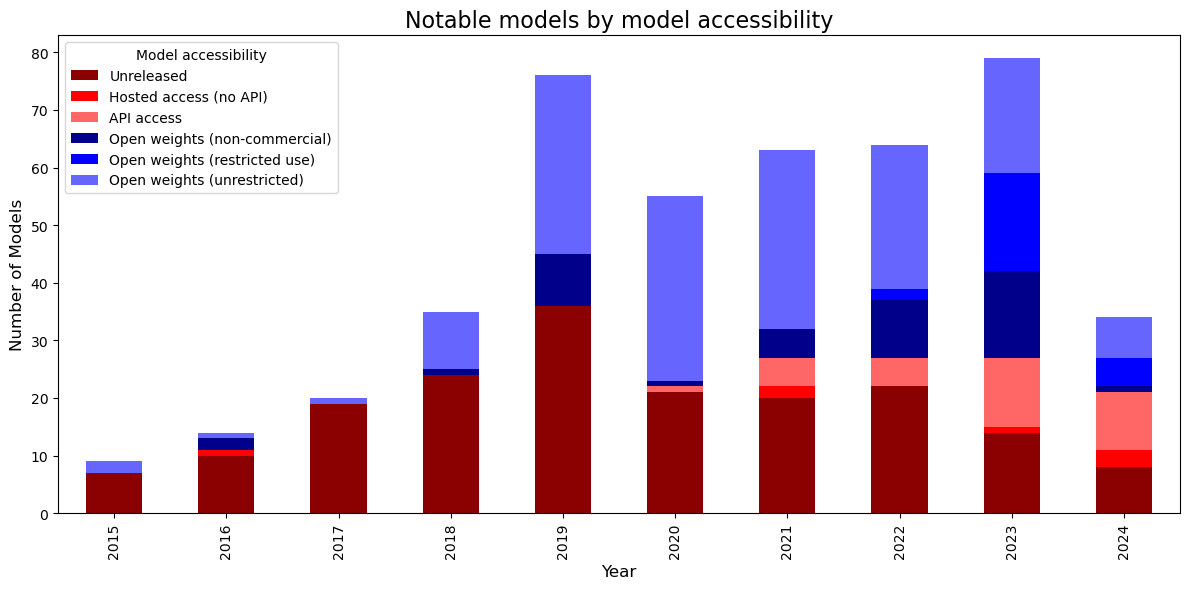

In [20]:
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['#8B0000', '#FF0000', '#FF6666', '#00008B', '#0000FF', '#6666FF']
notable_counts_year_pivot.plot(kind='bar', stacked=True, ax=ax, color=colors)

plt.title('Notable models by model accessibility', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Models', fontsize=12)


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [21]:
# get yearly totals, then join with existing data so we can find the relative proportions per year
notable_counts_yearly_total = notable_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')

notable_counts_year_pivot_totals = pd.merge(notable_counts_year_pivot, notable_counts_yearly_total, on='Year')
notable_counts_year_pivot_totals

,Year,Unreleased,Hosted access (no API),API access,Open weights (non-commercial),Open weights (restricted use),Open weights (unrestricted),Yearly Total
0,2015,7.0,0.0,0.0,0.0,0.0,2.0,9
1,2016,10.0,1.0,0.0,2.0,0.0,1.0,14
2,2017,19.0,0.0,0.0,0.0,0.0,1.0,20
3,2018,24.0,0.0,0.0,1.0,0.0,10.0,35
4,2019,36.0,0.0,0.0,9.0,0.0,31.0,76
5,2020,21.0,0.0,1.0,1.0,0.0,32.0,55
6,2021,20.0,2.0,5.0,5.0,0.0,31.0,63
7,2022,22.0,0.0,5.0,10.0,2.0,25.0,64
8,2023,14.0,1.0,12.0,15.0,17.0,20.0,79
9,2024,8.0,3.0,10.0,1.0,5.0,7.0,34


In [22]:
# replace model counts with proportions (relative to all notable models for the year)
notable_proportions = notable_counts_year_pivot_totals.copy()

columns_to_divide = notable_proportions.columns.drop(['Year', 'Yearly Total'])

for col in columns_to_divide:
    notable_proportions[col] = notable_proportions[col] / notable_proportions['Yearly Total']
notable_proportions.drop('Yearly Total', axis=1,inplace=True)
notable_proportions

,Year,Unreleased,Hosted access (no API),API access,Open weights (non-commercial),Open weights (restricted use),Open weights (unrestricted)
0,2015,0.777778,0.000000,0.000000,0.000000,0.000000,0.222222
1,2016,0.714286,0.071429,0.000000,0.142857,0.000000,0.071429
2,2017,0.950000,0.000000,0.000000,0.000000,0.000000,0.050000
3,2018,0.685714,0.000000,0.000000,0.028571,0.000000,0.285714
4,2019,0.473684,0.000000,0.000000,0.118421,0.000000,0.407895
5,2020,0.381818,0.000000,0.018182,0.018182,0.000000,0.581818
6,2021,0.317460,0.031746,0.079365,0.079365,0.000000,0.492063
7,2022,0.343750,0.000000,0.078125,0.156250,0.031250,0.390625
8,2023,0.177215,0.012658,0.151899,0.189873,0.215190,0.253165
9,2024,0.235294,0.088235,0.294118,0.029412,0.147059,0.205882


In [23]:
# repivot the dataframe for plotting: make it a Year by Model Accessibility dataframe
notable_proportions_reset = notable_proportions.reset_index()

melted_df = pd.melt(notable_proportions_reset, id_vars=['Year'], var_name='Model accessibility', value_name='Count')

notable_proportions_pivoted = melted_df.pivot(index='Year', columns='Model accessibility', values='Count')

# Reorder columns to match the original format
column_order = ['Unreleased', 'Hosted access (no API)', 'API access', 
                'Open weights (non-commercial)', 'Open weights (restricted use)', 
                'Open weights (unrestricted)']
notable_proportions_pivoted = notable_proportions_pivoted[column_order]

notable_proportions_pivoted = notable_proportions_pivoted[notable_proportions_pivoted.index >= 2018]
# Display the result
notable_proportions_pivoted

Model accessibility,Unreleased,Hosted access (no API),API access,Open weights (non-commercial),Open weights (restricted use),Open weights (unrestricted)
Year,,,,,,
2018,0.685714,0.000000,0.000000,0.028571,0.000000,0.285714
2019,0.473684,0.000000,0.000000,0.118421,0.000000,0.407895
2020,0.381818,0.000000,0.018182,0.018182,0.000000,0.581818
2021,0.317460,0.031746,0.079365,0.079365,0.000000,0.492063
2022,0.343750,0.000000,0.078125,0.156250,0.031250,0.390625
2023,0.177215,0.012658,0.151899,0.189873,0.215190,0.253165
2024,0.235294,0.088235,0.294118,0.029412,0.147059,0.205882


In [24]:
import plotly.graph_objects as go

fig = go.Figure()

# Add a bar trace for each column in notable_proportions_pivoted
for column in notable_proportions_pivoted.columns:
    fig.add_trace(go.Bar(
        x=notable_proportions_pivoted.index,
        y=notable_proportions_pivoted[column],
        name=column,
        marker_color=colors[notable_proportions_pivoted.columns.get_loc(column)]
    ))

fig.update_layout(
    title='Notable models have become more open over time',
    xaxis_title='Year',
    yaxis_title='Proportion of notable models',
    barmode='stack',
    legend=dict(x=1.05, y=1, traceorder='normal', orientation='v'),
    width=1000,
    height=600,
    template='plotly_white',
)

save_plot(fig, results_dir, f'notable_model_proportion_by_accessibility')
notable_proportions_pivoted.to_csv(results_dir + 'plot_data/notable_model_proportion_by_accessibility.csv')

fig.show()

In [25]:
# Input -  model counts, grouped by accessibility and by year
# Output - same dataframe with cumulative counts for status, cumulative total across all statuses, and proportion
def normalize_counts(access_counts):
    
    # Get df with total models per year, and cumulative totals
    total_counts = access_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')
    total_counts['Cumulative Total'] = total_counts['Yearly Total'].cumsum()
    
    # Pivot the access counts table to get counts for every status and every year
    # This will have many NaN values because not every year has a model of every status
    access_counts_wide = access_counts.pivot(index='Year', columns='Model accessibility', values='Cumulative for status')
    all_years = pd.Series(range(int(access_counts_wide.index.min()), int(access_counts_wide.index.max()) + 1))

    # Fill in the NaN values
    access_counts_wide_filled = access_counts_wide.reindex(all_years).ffill().fillna(0)
    access_counts_wide_filled = access_counts_wide_filled.reset_index(names=["Year"])
    
    # Unpivot
    access_counts_filled = (access_counts_wide_filled.melt(id_vars='Year', 
                                     var_name='Model accessibility', 
                                     value_name='Cumulative for status')
                               .reset_index(drop=True))
    
    # Join with total counts df to get the cumulative totals
    normalized_counts = pd.merge(access_counts_filled, total_counts, on='Year')
    
    # Divide annual counts by cumulative counts to find cumulative proportions by year
    normalized_counts['proportion'] = normalized_counts['Cumulative for status'] / normalized_counts['Cumulative Total']
    
    # Sort using custom order
    sort_order = ['Unreleased', 'Hosted access (no API)', 'API access', 'Open weights (non-commercial)', 'Open weights (restricted use)', 'Open weights (unrestricted)']
    normalized_counts['Category_sorted'] = pd.Categorical(normalized_counts['Model accessibility'], categories=sort_order, ordered=True)
    normalized_counts = normalized_counts.sort_values(['Category_sorted', 'Year'])
    
    return normalized_counts

In [26]:
normalized_counts_total = normalize_counts(access_counts)
normalized_counts_notable = normalize_counts(notable_counts)

In [27]:
# Create a 1x2 subplot
fig = make_subplots(rows=1, cols=2, subplot_titles=('Cumulative count',
                                                    'Cumulative proportion'))

# Define a consistent color palette
color_palette = {
    'Unreleased': '#d62728',
    'Hosted access (no API)': '#ff7f0e',
    'API access': '#8c564b',
    'Open weights (non-commercial)': '#9467bd',
    'Open weights (restricted use)': '#1f77b4',
    'Open weights (unrestricted)': '#2ca02c'
}

# Cumulative area chart
for accessibility in cumulative_notable_counts['Model accessibility'].unique():
    fig.add_trace(
        go.Scatter(x=cumulative_notable_counts[cumulative_notable_counts['Model accessibility'] == accessibility]['Year'], 
                y=cumulative_notable_counts[cumulative_notable_counts['Model accessibility'] == accessibility]['Cumulative for status'], 
                hoverinfo='x+y',
                stackgroup='one',
                mode='lines',
                name=accessibility,
                line=dict(color=color_palette[accessibility])),
        row=1, col=1
    )

# Normalized area chart
for accessibility in normalized_counts_notable['Model accessibility'].unique():
    fig.add_trace(
        go.Scatter(x=normalized_counts_notable[normalized_counts_notable['Model accessibility'] == accessibility]['Year'], 
                y=normalized_counts_notable[normalized_counts_notable['Model accessibility'] == accessibility]['proportion'], 
                hoverinfo='x+y',
                stackgroup='one',
                mode='lines',
                name=accessibility,
                line=dict(color=color_palette[accessibility]),
                showlegend=False),
        row=1, col=2
    )

# Update layout
fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
    title_text='Notable models accessibility over time',
    showlegend=True
)

# Update x and y axes
fig.update_xaxes(title_text='Year', range=[2018, 2024], row=1, col=1)
fig.update_xaxes(title_text='Year', range=[2018, 2024], row=1, col=2)
fig.update_yaxes(title_text='Cumulative count', row=1, col=1)
fig.update_yaxes(title_text='Cumulative proportion', range=[0, 1], row=1, col=2)

save_plot(fig, results_dir, f'cumulative_model_count_by_accessibility')

fig.show()

This chart shows the proportions over time more clearly - open weights have never been very rare (at least 10%). But open models have become much more common over time, making up around half of models today. The large majority of those are permissively licensed ("Open weights (unrestricted)") even today but open with restrictions has become more common over time.

In [28]:
fig = px.area(normalized_counts_notable, x='Year', y='proportion', color='Model accessibility', line_group='Model accessibility',
              labels={'proportion': 'Cumulative proportion of notable models', 'Year': 'Year'},
              title='An increasing share of notable models have open weights')

fig.update_yaxes(range=[0, 1])
fig.update_xaxes(range=[2018, 2024])
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.2,
)

save_plot(fig, results_dir, f'notable_model_proportion_by_accessibility_area')

fig.show()

In [29]:
fig = px.area(normalized_counts_total, x='Year', y='proportion', color='Model accessibility', line_group='Model accessibility',
              labels={'proportion': 'Proportion', 'Year': 'Year'},
              title='Cumulative proportion of all models by accessibility over time')

fig.update_yaxes(range=[0, 1])
fig.update_xaxes(range=[2018, 2024])
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.2,
)
# save_plot(fig, results_dir, f'proportion_by_accessibility')
fig.show()

# Code vs Model Accessibility

In [30]:
print(f"There are {len(access_df[access_df['Training code accessibility'].isna()])} models with marked model access and unmarked code access")

There are 146 models with marked model access and unmarked code access


In [31]:
# filter for code accessibility
code_df = access_df.dropna(subset=['Training code accessibility'])

In [32]:
code_df.head(8)

,System,Domain,Task,Authors,Notability criteria,Notability criteria notes,Model accessibility,Link,Citations,Reference,...,Hardware TF16,Hardware FP16,Assumed precision,Assumed hardware FLOP/s,Hardware type,Compute estimate method,Training compute estimation method,Model open/closed,Code open/closed,Year
0,Gemini 1.0 Ultra,"Multimodal,Language,Vision","Language modelling,Visual question answering,C...",Gemini Team,"SOTA improvement,Training cost",""" Evaluation on a broad range of benchmarks sh...",API access,https://storage.googleapis.com/deepmind-media/...,633.0,Gemini: A Family of Highly Capable Multimodal ...,...,275000000000000,NaN,TF16,275000000000000,TPU,NaN,NaN,Closed,Closed,2023
1,Llama 3.1-405B,Language,Language modelling/generation,"Abhimanyu Dubey, Abhinav Jauhri, Abhinav Pande...","SOTA improvement,Training cost","High training compute, exceeds 4o and Claude 3...",Open weights (restricted use),https://ai.meta.com/research/publications/the-...,NaN,The Llama 3 Herd of Models,...,989500000000000,133800000000000.0000,TF16,989500000000000,GPU,NaN,"Reported,Operation counting",Open,Open,2024
2,Mistral Large 2,Language,"Language modelling/generation,Translation,Code...","Albert Jiang, Alexandre Sablayrolles, Alexis T...",Training cost,likely high training cost since previous Mistr...,Open weights (non-commercial),https://mistral.ai/news/mistral-large-2407/,NaN,"Top-tier reasoning for high-complexity tasks, ...",...,NaN,NaN,FP32,NaN,NaN,NaN,"Hardware,Cost,Benchmarks",Open,Closed,2024
3,GPT-4,"Multimodal,Language,Vision,Image generation",Language modelling,"OpenAI, Josh Achiam, Steven Adler, Sandhini Ag...","Highly cited,SOTA improvement,Training cost","See the paper, p.1: ""On a suite of traditional...",API access,https://arxiv.org/abs/2303.08774,7054.0,GPT-4 Technical Report,...,311840000000000,77970000000000.0000,TF16,311840000000000,GPU,NaN,NaN,Closed,Closed,2023
4,Nemotron-4 340B,Language,"Language modelling/generation,Chat","Bo Adler, Niket Agarwal, Ashwath Aithal, Dong ...",Training cost,"~2e25 FLOP, so high training cost, likely >5M",Open weights (unrestricted),https://blogs.nvidia.com/blog/nemotron-4-synth...,NaN,NVIDIA Releases Open Synthetic Data Generation...,...,989500000000000,133800000000000.0000,TF16,989500000000000,GPU,NaN,NaN,Open,Closed,2024
6,MegaScale (Production),Language,Language modelling/generation,"Ziheng Jiang, Haibin Lin, Yinmin Zhong, Qi Hua...",SOTA improvement,Improves SOTA in FLOP utilization for distribu...,Unreleased,https://arxiv.org/abs/2402.15627,31.0,MegaScale: Scaling Large Language Model Traini...,...,312000000000000,77970000000000.0000,TF16,312000000000000,GPU,NaN,NaN,Closed,Closed,2024
8,Mistral Large,Language,Chat,NaN,Training cost,~$20M training cost: https://www.wsj.com/tech/...,API access,https://mistral.ai/news/mistral-large/,NaN,"Mistral Large, our new flagship model",...,756000000000000,204900000000000.0000,TF16,756000000000000,NaN,NaN,NaN,Closed,Closed,2024
9,Inflection-2,Language,"Language modelling,Language modelling/generati...",NaN,"Significant use,Training cost",Inflection-2 either already powers Pi or soon ...,Hosted access (no API),https://inflection.ai/inflection-2,NaN,Inflection-2: The Next Step Up,...,989500000000000,133800000000000.0000,TF16,989500000000000,GPU,NaN,NaN,Closed,Closed,2023


In [33]:
model_counts = code_df.groupby('Model accessibility').size().reset_index(name='Counts')
model_counts

,Model accessibility,Counts
0,API access,46
1,Hosted access (no API),26
2,Open weights (non-commercial),80
3,Open weights (restricted use),67
4,Open weights (unrestricted),281
5,Unreleased,447


In [34]:
code_counts = code_df.groupby('Training code accessibility').size().reset_index(name='Counts')
code_counts

,Training code accessibility,Counts
0,Open (non-commercial),77
1,Open (restricted use),10
2,Open source,317
3,Unreleased,543


In [35]:
grouped_counts = code_df.groupby(['Model accessibility', 'Training code accessibility']).size().reset_index(name='Counts')
pivoted = grouped_counts.pivot(index='Model accessibility', columns='Training code accessibility', values='Counts').fillna(0)

# code access against model access
pivoted

Training code accessibility,Open (non-commercial),Open (restricted use),Open source,Unreleased
Model accessibility,,,,
API access,0.0,0.0,0.0,46.0
Hosted access (no API),1.0,0.0,1.0,24.0
Open weights (non-commercial),32.0,1.0,16.0,31.0
Open weights (restricted use),0.0,7.0,12.0,48.0
Open weights (unrestricted),1.0,1.0,182.0,97.0
Unreleased,43.0,1.0,106.0,297.0


In [36]:
model_code_counts = code_df.groupby(['Model open/closed', 'Code open/closed']).size().reset_index(name='Counts')
model_code_counts = model_code_counts.pivot(index='Model open/closed', columns='Code open/closed', values='Counts')

# code open vs model open
model_code_counts

Code open/closed,Closed,Open
Model open/closed,,
Closed,367,152
Open,176,252


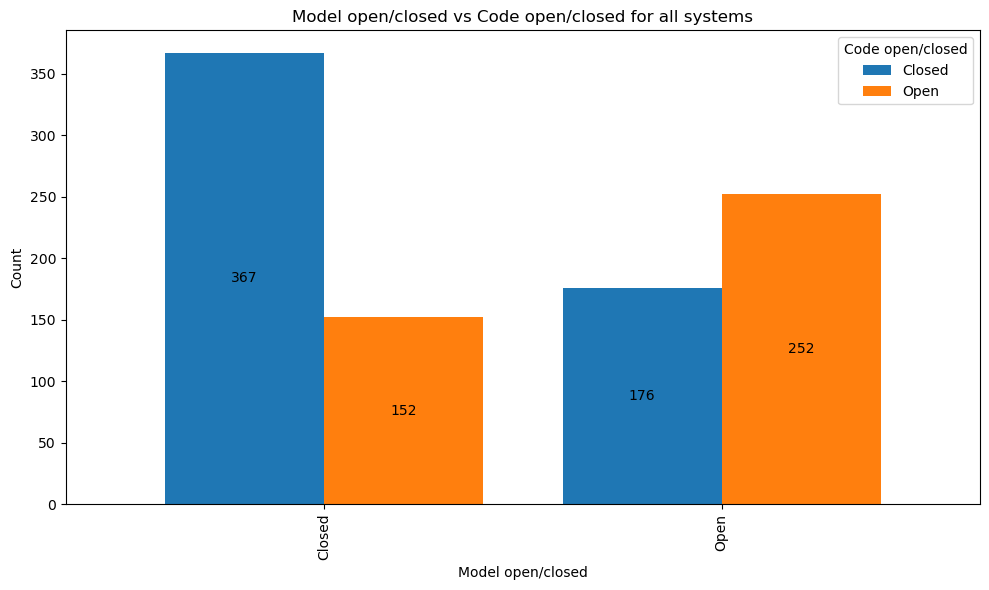

In [37]:
ax = model_code_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

# Customize the chart
plt.title('Model open/closed vs Code open/closed for all systems')
plt.ylabel('Count')


# Add value labels on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='center')

# Adjust layout and display the chart
plt.tight_layout()
plt.show()

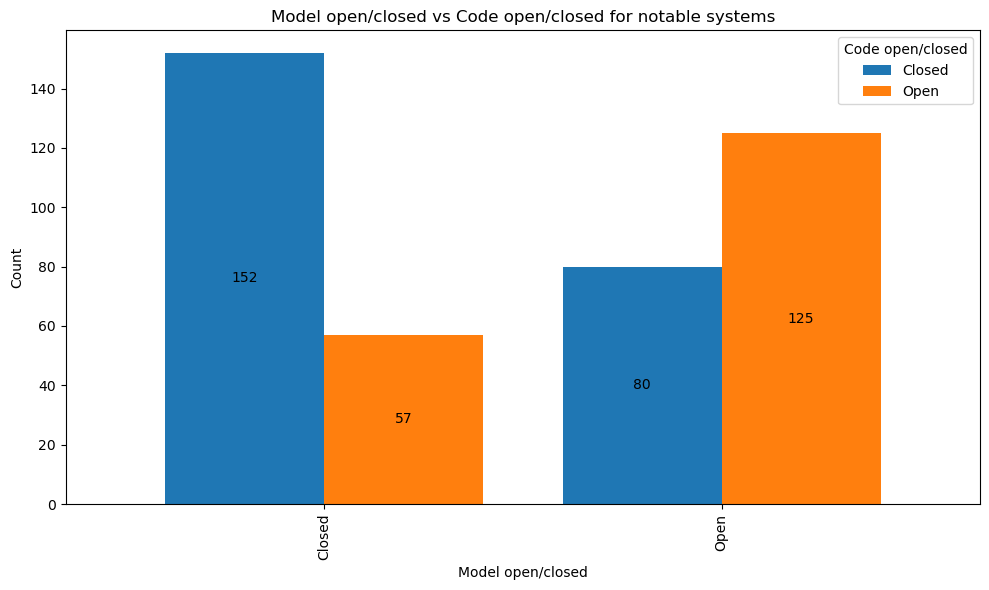

In [38]:
notable_code_df = code_df.loc[(code_df['Notability criteria'].notna())]

notable_open_counts = notable_code_df.groupby(['Model open/closed', 'Code open/closed']).size().reset_index(name='Counts')
notable_open_counts = notable_open_counts.pivot(index='Model open/closed', columns='Code open/closed', values='Counts')

ax = notable_open_counts.plot(kind='bar', figsize=(10, 6), width=0.8)

plt.title('Model open/closed vs Code open/closed for notable systems')
plt.ylabel('Count')

for container in ax.containers:
    ax.bar_label(container, label_type='center')

plt.tight_layout()
plt.show()

In [39]:
notable_open_counts

Code open/closed,Closed,Open
Model open/closed,,
Closed,152,57
Open,80,125


In [40]:
import plotly.graph_objects as go

# Data
z = [[152, 57],
     [80, 125]]

fig = go.Figure(data=go.Heatmap(
    z=notable_open_counts.values,
    x=notable_open_counts.columns,
    y=notable_open_counts.index,
    hoverongaps = False,
    text=z,
    texttemplate="%{text}",
    textfont={"size":20},
    colorscale='Blues'
))


fig.update_layout(
    autosize=False,
    width=400,
    height=300,
    title='Model and training code accessibility',
    xaxis_title='Code open/closed',
    yaxis_title='Model open/closed'
)

save_plot(fig, results_dir, f'model_code_accessibility_heatmap')
notable_open_counts.to_csv(results_dir + 'plot_data/model_code_accessibility_heatmap.csv')

fig.show()

Model openness and code openness are reasonably correlated - most closed-weight models have closed code, while somewhat more open models have open code than closed code. This also applies across the other direction - most closed code models have closed weights, most open code models have open weights.

In [41]:
open_counts = code_df.loc[code_df['Year'] >= 2015].groupby(['Year', 'Model open/closed', 'Code open/closed']).size().reset_index(name='Count')

open_counts['Cumulative'] = open_counts.groupby(['Model open/closed', 'Code open/closed'])['Count'].cumsum()

open_counts.head(10)

,Year,Model open/closed,Code open/closed,Count,Cumulative
0,2015,Closed,Closed,7,7
1,2015,Closed,Open,1,1
2,2015,Open,Open,3,3
3,2016,Closed,Closed,19,26
4,2016,Closed,Open,4,5
5,2016,Open,Closed,1,1
6,2016,Open,Open,2,5
7,2017,Closed,Closed,21,47
8,2017,Closed,Open,13,18
9,2017,Open,Open,2,7


In [42]:
total_counts = open_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')
total_counts['Cumulative Total'] = total_counts['Yearly Total'].cumsum()
total_counts

,Year,Yearly Total,Cumulative Total
0,2015,11,11
1,2016,26,37
2,2017,36,73
3,2018,65,138
4,2019,139,277
5,2020,91,368
6,2021,140,508
7,2022,121,629
8,2023,195,824
9,2024,98,922


In [43]:
open_counts_wide = open_counts.pivot(index='Year', columns=['Model open/closed', 'Code open/closed'], values='Count')
open_counts_wide = open_counts_wide.fillna(0).reset_index()
open_counts_wide

Model open/closed  Year Closed        Open       
Code open/closed        Closed  Open  Open Closed
0                  2015    7.0   1.0   3.0    0.0
1                  2016   19.0   4.0   2.0    1.0
2                  2017   21.0  13.0   2.0    0.0
3                  2018   32.0  11.0  19.0    3.0
4                  2019   58.0  35.0  37.0    9.0
5                  2020   41.0  14.0  22.0   14.0
6                  2021   50.0  31.0  46.0   13.0
7                  2022   32.0  22.0  39.0   28.0
8                  2023   51.0  11.0  65.0   68.0
9                  2024   39.0   2.0  17.0   40.0

In [44]:
print(open_counts_wide.columns.to_list())
print(open_counts_wide.index.names)

[('Year', ''), ('Closed', 'Closed'), ('Closed', 'Open'), ('Open', 'Open'), ('Open', 'Closed')]
[None]


In [45]:
# Convert pivoted multi-columns to single columns with clear names
new_columns = ['Year'] + [f'Model {outer} Code {inner}' for outer, inner in open_counts_wide.columns[1:]]
open_counts_wide.columns = new_columns

open_counts_wide

,Year,Model Closed Code Closed,Model Closed Code Open,Model Open Code Open,Model Open Code Closed
0,2015,7.0,1.0,3.0,0.0
1,2016,19.0,4.0,2.0,1.0
2,2017,21.0,13.0,2.0,0.0
3,2018,32.0,11.0,19.0,3.0
4,2019,58.0,35.0,37.0,9.0
5,2020,41.0,14.0,22.0,14.0
6,2021,50.0,31.0,46.0,13.0
7,2022,32.0,22.0,39.0,28.0
8,2023,51.0,11.0,65.0,68.0
9,2024,39.0,2.0,17.0,40.0


In [46]:
# unpivot table to get the count of each 2x2 value for each year
open_counts_filled = (open_counts_wide.melt(id_vars=['Year'], 
                                            var_name='Category',
                                            value_name='Count')
                                      .reset_index(drop=True))

open_counts_filled.head(20)

,Year,Category,Count
0,2015,Model Closed Code Closed,7.0
1,2016,Model Closed Code Closed,19.0
2,2017,Model Closed Code Closed,21.0
3,2018,Model Closed Code Closed,32.0
4,2019,Model Closed Code Closed,58.0
5,2020,Model Closed Code Closed,41.0
6,2021,Model Closed Code Closed,50.0
7,2022,Model Closed Code Closed,32.0
8,2023,Model Closed Code Closed,51.0
9,2024,Model Closed Code Closed,39.0


In [47]:
yearly_with_totals = pd.merge(open_counts_filled, total_counts, on="Year")
yearly_with_totals["Proportion for year"] = yearly_with_totals["Count"] / yearly_with_totals["Yearly Total"]
yearly_with_totals = yearly_with_totals.drop(labels=["Cumulative Total"],axis=1)
yearly_with_totals

,Year,Category,Count,Yearly Total,Proportion for year
0,2015,Model Closed Code Closed,7.0,11,0.636364
1,2016,Model Closed Code Closed,19.0,26,0.730769
2,2017,Model Closed Code Closed,21.0,36,0.583333
3,2018,Model Closed Code Closed,32.0,65,0.492308
4,2019,Model Closed Code Closed,58.0,139,0.417266
5,2020,Model Closed Code Closed,41.0,91,0.450549
6,2021,Model Closed Code Closed,50.0,140,0.357143
7,2022,Model Closed Code Closed,32.0,121,0.264463
8,2023,Model Closed Code Closed,51.0,195,0.261538
9,2024,Model Closed Code Closed,39.0,98,0.397959


In [48]:
yearly_with_totals_pivot = yearly_with_totals.pivot(index="Year", columns="Category", values="Proportion for year").fillna(0)
yearly_with_totals_pivot = yearly_with_totals_pivot[yearly_with_totals_pivot.index >= 2018]
yearly_with_totals_pivot

Category,Model Closed Code Closed,Model Closed Code Open,Model Open Code Closed,Model Open Code Open
Year,,,,
2018,0.492308,0.169231,0.046154,0.292308
2019,0.417266,0.251799,0.064748,0.266187
2020,0.450549,0.153846,0.153846,0.241758
2021,0.357143,0.221429,0.092857,0.328571
2022,0.264463,0.181818,0.231405,0.322314
2023,0.261538,0.056410,0.348718,0.333333
2024,0.397959,0.020408,0.408163,0.173469


In [49]:
import plotly.graph_objects as go

fig = go.Figure()

colors = ['crimson', 'tomato', 'blue', 'dodgerblue']

for i, category in enumerate(yearly_with_totals_pivot.columns):
    fig.add_trace(go.Bar(
        x=yearly_with_totals_pivot.index,
        y=yearly_with_totals_pivot[category],
        name=category,
        marker_color=colors[i]
    ))

fig.update_layout(
    title='Proportion of notable models with open or closed weights or code',
    xaxis_title='Year',
    yaxis_title='Proportion',
    barmode='stack',
    legend=dict(x=1.05, y=1, traceorder='normal', orientation='v'),
    width=1000,
    height=600,
    template='plotly_white',
)

save_plot(fig, results_dir, f'notable_model_code_accessibility_over_time')
yearly_with_totals_pivot.to_csv(results_dir + 'plot_data/notable_model_code_accessibility_over_time.csv')

fig.show()

In [50]:
open_counts_filled['Cumulative for Category'] = open_counts_filled.groupby('Category')['Count'].cumsum()

with_totals = pd.merge(open_counts_filled, total_counts, on="Year")
with_totals['proportion'] = with_totals['Cumulative for Category'] / with_totals['Cumulative Total']
with_totals.head(20)

,Year,Category,Count,Cumulative for Category,Yearly Total,Cumulative Total,proportion
0,2015,Model Closed Code Closed,7.0,7.0,11,11,0.636364
1,2016,Model Closed Code Closed,19.0,26.0,26,37,0.702703
2,2017,Model Closed Code Closed,21.0,47.0,36,73,0.643836
3,2018,Model Closed Code Closed,32.0,79.0,65,138,0.572464
4,2019,Model Closed Code Closed,58.0,137.0,139,277,0.494585
5,2020,Model Closed Code Closed,41.0,178.0,91,368,0.483696
6,2021,Model Closed Code Closed,50.0,228.0,140,508,0.448819
7,2022,Model Closed Code Closed,32.0,260.0,121,629,0.413355
8,2023,Model Closed Code Closed,51.0,311.0,195,824,0.377427
9,2024,Model Closed Code Closed,39.0,350.0,98,922,0.379610


In [51]:
# sort using custom order
sort_order = ['Model Closed Code Closed', 'Model Closed Code Open', 'Model Open Code Closed', 'Model Open Code Open']

with_totals['Category_sorted'] = pd.Categorical(with_totals['Category'], categories=sort_order, ordered=True)
with_totals = with_totals.sort_values('Category_sorted')


colors = ['crimson', 'tomato', 'blue', 'dodgerblue']
fig = px.area(with_totals, x='Year', y='proportion', color='Category', line_group='Category',
              labels={'proportion': 'Proportion', 'Year': 'Year', 'Category': 'Accessibility'},
              title='Cumulative proportion of model and training code accessibility, all models', color_discrete_sequence=colors)

fig.update_yaxes(range=[0, 1])
fig.update_xaxes(range=[2018, 2024])
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.2,
)

save_plot(fig, results_dir, f'model_code_accessibility_over_time')

fig.show()

This chart shows the proportions across the four categories of model open/closed and code open/closed. The blue areas are open-weight models and the red areas are closed-weight, while the lighter colors are code open and the darker colors are code closed. Among open-weight models, code closed has become more common. Intuitively, this is consistent with the rise of the commercial open-source industry, which releases model weights but does not wish to give competitors the ability to recreate their base models.

In [52]:
# repeat the above code but with notable models only
open_counts = notable_code_df.loc[code_df['Year'] >= 2015].groupby(['Year', 'Model open/closed', 'Code open/closed']).size().reset_index(name='Count')

open_counts['Cumulative'] = open_counts.groupby(['Model open/closed', 'Code open/closed'])['Count'].cumsum()

total_counts = open_counts.groupby('Year')['Count'].sum().reset_index(name='Yearly Total')
total_counts['Cumulative Total'] = total_counts['Yearly Total'].cumsum()

open_counts_wide = open_counts.pivot(index='Year', columns=['Model open/closed', 'Code open/closed'], values='Count')
open_counts_wide = open_counts_wide.fillna(0).reset_index()

# Convert pivoted multi-columns to single columns with clear names
new_columns = ['Year'] + [f'Model {outer} Code {inner}' for outer, inner in open_counts_wide.columns[1:]]
open_counts_wide.columns = new_columns

# unpivot table to get the count of each 2x2 value for each year
open_counts_filled = (open_counts_wide.melt(id_vars=['Year'], 
                                            var_name='Category',
                                            value_name='Count')
                                      .reset_index(drop=True))

open_counts_filled['Cumulative for Category'] = open_counts_filled.groupby('Category')['Count'].cumsum()

with_totals = pd.merge(open_counts_filled, total_counts, on="Year")
with_totals['proportion'] = with_totals['Cumulative for Category'] / with_totals['Cumulative Total']

# sort using custom order
sort_order = ['Model Closed Code Closed', 'Model Closed Code Open', 'Model Open Code Closed', 'Model Open Code Open']

with_totals['Category_sorted'] = pd.Categorical(with_totals['Category'], categories=sort_order, ordered=True)
with_totals = with_totals.sort_values('Category_sorted')


colors = ['crimson', 'tomato', 'blue', 'dodgerblue']
fig = px.area(with_totals, x='Year', y='proportion', color='Category', line_group='Category',
              labels={'proportion': 'Proportion', 'Year': 'Year'},
              title='Cumulative Proportion of Notable Models by Mode/Code Openness', color_discrete_sequence=colors)

fig.update_yaxes(range=[0, 1])
fig.update_xaxes(range=[2018, 2024])
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    title_x=0.2,
)
fig

In [53]:
notable_df['Academia'] = notable_df['Organization categorization'].str.contains('Academia', case=False, na=False)
notable_df['Industry'] = notable_df['Organization categorization'].str.contains('Industry', case=False, na=False)

/var/folders/s2/stl5t_bn7xg9vdfxxr71rzrc0000gn/T/ipykernel_59726/2300436354.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/s2/stl5t_bn7xg9vdfxxr71rzrc0000gn/T/ipykernel_59726/2300436354.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Surveying developers of open models

In [54]:
open_model_closed_code = notable_df[(notable_df['Model open/closed'] == 'Open') 
                                    & (notable_df['Code open/closed'] == 'Closed')]

open_model_open_code = notable_df[(notable_df['Model open/closed'] == 'Open') 
                                    & (notable_df['Code open/closed'] == 'Open')]

In [55]:
open_model_open_code.groupby('Academia')['System'].count()

Academia
False    58
True     67
Name: System, dtype: int64

In [56]:
open_model_open_code.groupby('Industry')['System'].count()

Industry
False    29
True     96
Name: System, dtype: int64

In [57]:
open_model_closed_code.groupby('Academia')['System'].count()

Academia
False    59
True     44
Name: System, dtype: int64

In [58]:
open_model_closed_code.groupby('Industry')['System'].count()

Industry
False    14
True     89
Name: System, dtype: int64

In [59]:
nonacademia, academia = open_model_closed_code.groupby('Academia')['System'].count()
print(f'{round(100*academia/(academia+nonacademia))}% of open-weight closed-code models were developed by academia')

nonindustry, industry = open_model_closed_code.groupby('Industry')['System'].count()
print(f'{round(100*industry/(industry+nonindustry))}% of open-weight closed-code models were developed by industry\n')

nonacademia, academia = open_model_open_code.groupby('Academia')['System'].count()
print(f'{round(100*academia/(academia+nonacademia))}% of open-weight open-code models were developed by academia')

nonindustry, industry = open_model_open_code.groupby('Industry')['System'].count()
print(f'{round(100*industry/(industry+nonindustry))}% of open-weight open-code models were developed by industry')

43% of open-weight closed-code models were developed by academia
86% of open-weight closed-code models were developed by industry

54% of open-weight open-code models were developed by academia
77% of open-weight open-code models were developed by industry


Percentages above add up to above 100% because many models were co-developed by industry and academia

In [60]:
notable_df[(notable_df['Academia']==True) & (notable_df['Year']>=2015) & (notable_df['Year']<=2023)].groupby(['Year', 'Model open/closed']).size()

Year  Model open/closed
2015  Closed                5
2016  Closed                3
      Open                  3
2017  Closed               10
      Open                  1
2018  Closed               14
      Open                  4
2019  Closed               20
      Open                 15
2020  Closed                9
      Open                 19
2021  Closed                7
      Open                 18
2022  Closed                4
      Open                 22
2023  Closed                4
      Open                 26
dtype: int64

In [61]:
academic_by_year = notable_df[(notable_df['Academia']==True) & (notable_df['Year']>=2015) & (notable_df['Year']<=2023)].groupby(['Year', 'Model open/closed']).size().reset_index(name='Count')



# Pivot the data for plotting
academic_by_year_pivot = academic_by_year.pivot(index='Year', columns='Model open/closed', values='Count').fillna(0)

academic_by_year_pivot

Model open/closed,Closed,Open
Year,,
2015,5.0,0.0
2016,3.0,3.0
2017,10.0,1.0
2018,14.0,4.0
2019,20.0,15.0
2020,9.0,19.0
2021,7.0,18.0
2022,4.0,22.0
2023,4.0,26.0


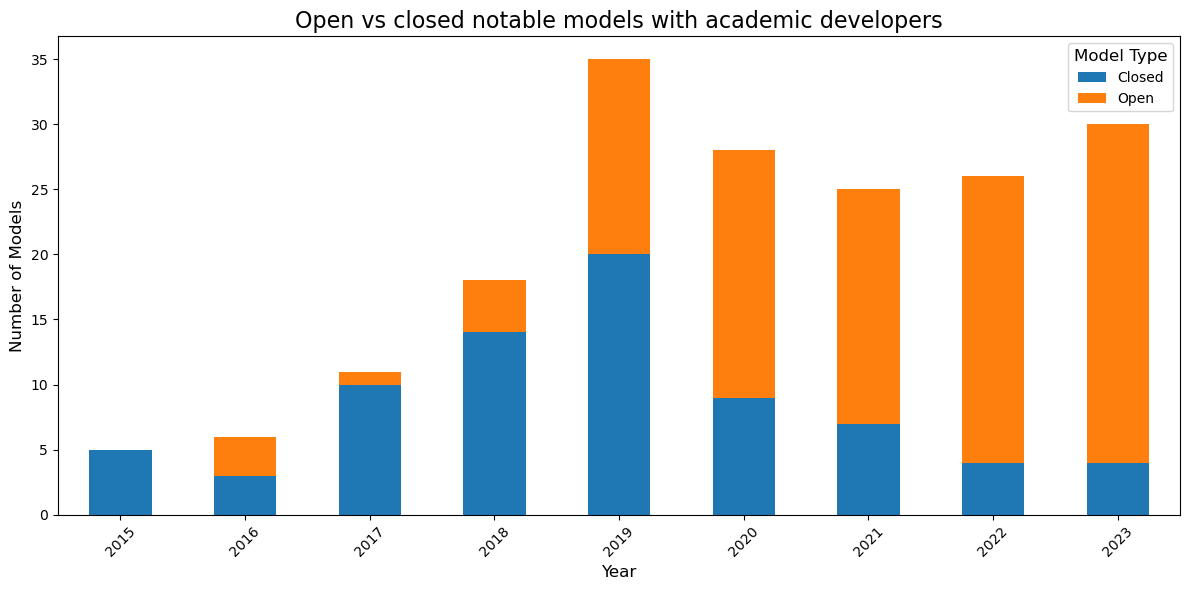

In [62]:

fig, ax = plt.subplots(figsize=(12, 6))
academic_by_year_pivot.plot(kind='bar', stacked=True, ax=ax)

plt.title('Open vs closed notable models with academic developers', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Models', fontsize=12)
plt.legend(title='Model Type', title_fontsize='12', fontsize='10')
plt.xticks(rotation=45)


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [63]:
academic_only_by_year = notable_df[(notable_df['Academia']==True) 
                                        & (notable_df['Industry']==False) 
                                        & (notable_df['Year']>=2015) 
                                        & (notable_df['Year']<=2023)].groupby(['Year', 'Model open/closed']).size().reset_index(name='Count')

# Pivot the data for plotting
academic_only_by_year_pivot = academic_only_by_year.pivot(index='Year', columns='Model open/closed', values='Count').fillna(0)

academic_only_by_year_pivot

Model open/closed,Closed,Open
Year,,
2015,3.0,0.0
2016,2.0,3.0
2017,6.0,1.0
2018,4.0,1.0
2019,8.0,7.0
2020,3.0,7.0
2021,3.0,3.0
2022,0.0,7.0
2023,1.0,8.0


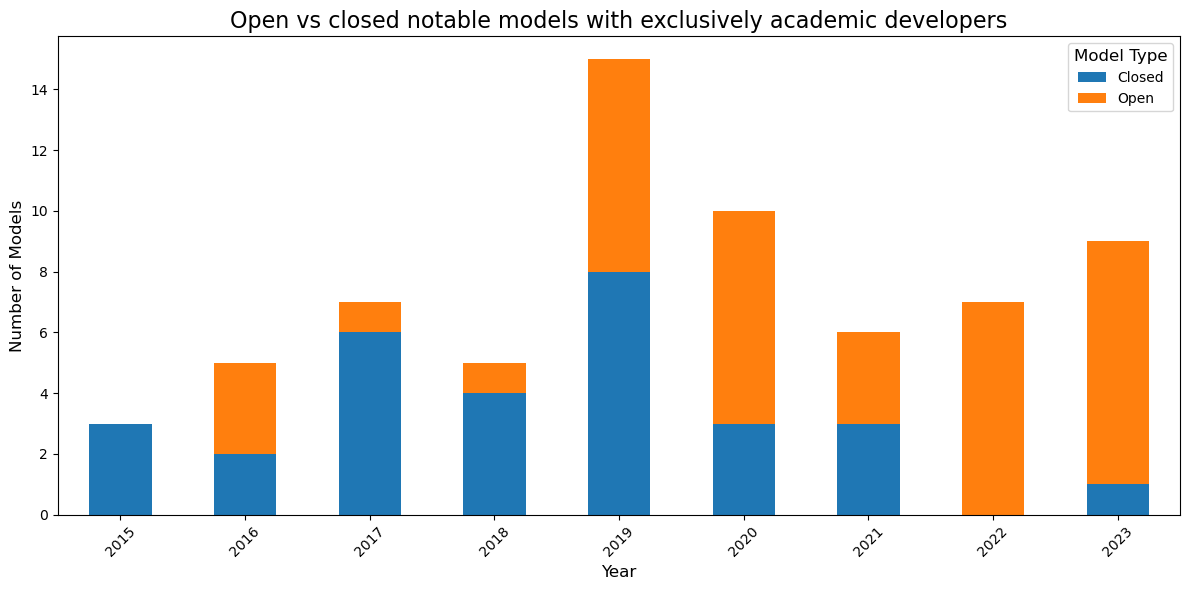

In [64]:
fig, ax = plt.subplots(figsize=(12, 6))
academic_only_by_year_pivot.plot(kind='bar', stacked=True, ax=ax)

plt.title('Open vs closed notable models with exclusively academic developers', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Models', fontsize=12)
plt.legend(title='Model Type', title_fontsize='12', fontsize='10')
plt.xticks(rotation=45)


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [65]:
industry_only_by_year = notable_df[(notable_df['Academia']==False) 
                                        & (notable_df['Industry']==True) 
                                        & (notable_df['Year']>=2015) 
                                        & (notable_df['Year']<=2023)].groupby(['Year', 'Model open/closed']).size().reset_index(name='Count')

# Pivot the data for plotting
industry_only_by_year_pivot = industry_only_by_year.pivot(index='Year', columns='Model open/closed', values='Count').fillna(0)

industry_only_by_year_pivot

Model open/closed,Closed,Open
Year,,
2015,2.0,1.0
2016,8.0,0.0
2017,9.0,0.0
2018,10.0,7.0
2019,16.0,23.0
2020,13.0,14.0
2021,20.0,18.0
2022,23.0,14.0
2023,23.0,24.0


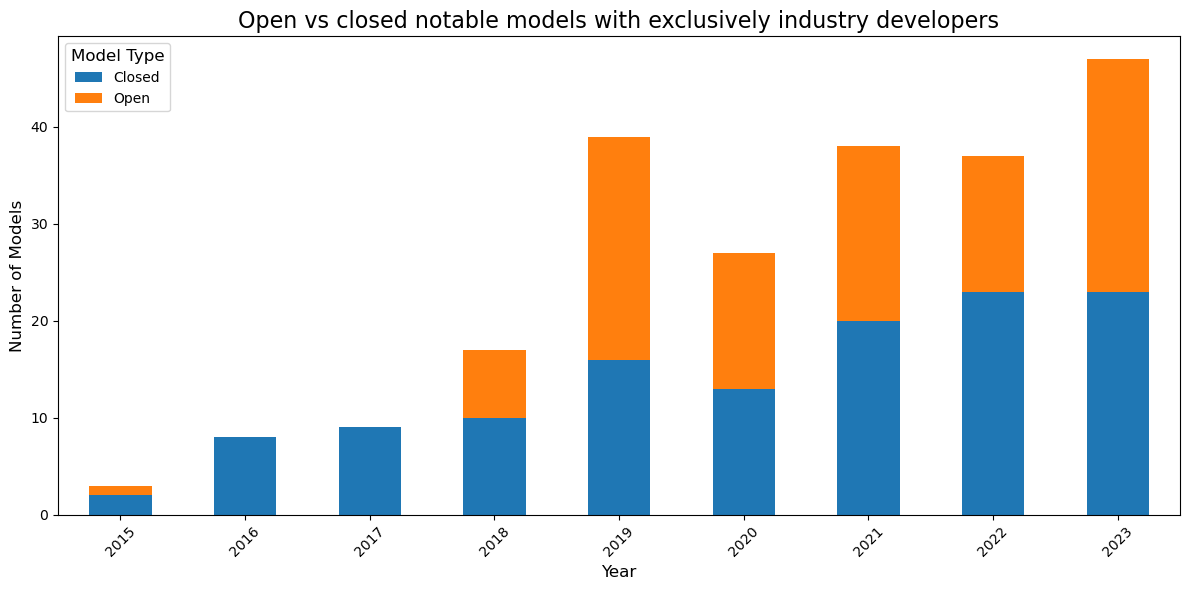

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))
industry_only_by_year_pivot.plot(kind='bar', stacked=True, ax=ax)

plt.title('Open vs closed notable models with exclusively industry developers', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Models', fontsize=12)
plt.legend(title='Model Type', title_fontsize='12', fontsize='10')
plt.xticks(rotation=45)


# Adjust layout and display the plot
plt.tight_layout()
plt.show()